In [104]:
# Load experimental results from files.

from pathlib import Path
import re
import yaml
from yaml import SafeLoader

EXP_PATH = "/home/hazrael/GitRepositories/storalloc-gitlab/simulation/results"
# EXP_NAME = ["exp__08-Mar-22_11-14", "exp__09-Mar-22_09-46", "exp__09-Mar-22_13-05"]
EXP_NAME = ["exp__16-Mar-22_18-08"]

exp_data = []

infra_pattern = re.compile(r"infra\d+TB")
system_pattern = re.compile(r"(single|multi)(_[a-z]+){3}")
algo_pattern = re.compile(r"(\S+)_infra\d+TB")

for name in EXP_NAME:
    exp_path = Path(f"{EXP_PATH}/{name}")
    result_files = exp_path.glob("*.yml")

    for file in result_files:
        with open(file, "r", encoding="utf-8") as yaml_file:
            exp = yaml.load(yaml_file, Loader=SafeLoader)
            exp["full_name"] = file.stem.split('__')[1]
            exp["infra"] = infra_pattern.findall(exp["full_name"])[0]
            exp["system"] = system_pattern.search(exp["full_name"])[0]
            exp["algo"] = algo_pattern.search(exp['full_name'])[1]
            exp_data.append(exp)

In [105]:
# Load them (almost) unprocessed into a DataFrame

import pandas as pd

df_data = pd.DataFrame(exp_data)
# df_data

In [106]:
# Compute some means (per node / disk) extracted from the "nodes" column 
# and add them as new columns in the original dataset

# New columns
mean_node_alloc = [] # extracted from existing field
max_node_alloc = []
mean_node_utilisation = []


for idx, row in df_data.iterrows():

    acc_mean_node_alloc = []
    acc_max_disk_alloc = []
    acc_mean_cap_utilisation = []
    # print(row['nodes'])
    ## NODES
    for node in row["nodes"]:
        # print(node)
        
        acc_mean_node_alloc.append(node["mean_nb_alloc"])
        
        max_disk_alloc = []
        mean_disk_alloc = []
        max_cap_utilisation = []
        mean_cap_utilisation = []

        # DISKS
        for disk in node["disks"]:
            # print(disk["max_alloc"])
            acc_max_disk_alloc.append(disk["max_alloc"])
            mean_disk_alloc.append(disk["mean_nb_alloc"])
            max_cap_utilisation.append(disk["max_cap_utilisation"])
            mean_cap_utilisation.append(disk["mean_capacity_utilisation"])
        
        
        mean_disk_alloc = pd.Series(mean_disk_alloc).mean()
        acc_mean_cap_utilisation = pd.Series(mean_cap_utilisation).mean()
    
    # Building future column for DataFrame
    mean_node_alloc.append(pd.Series(acc_mean_node_alloc).mean())
    max_node_alloc.append(max(acc_max_disk_alloc))
    mean_node_utilisation.append(pd.Series(acc_mean_cap_utilisation).mean())
    
    
df_data["mean_node_alloc"] = mean_node_alloc
df_data["max_node_alloc"] = max_node_alloc
df_data["mean_node_utilisation"] = mean_node_utilisation

In [107]:
df_data.describe()

,max_concurrent_allocations,nb_of_delayed_requests,nb_of_registrations,nb_of_requests,nb_of_scheduler_failures,sim_duration,sim_first_ts,sim_last_ts,tt_gb_allocated,tt_gb_deallocated,tt_waiting_time_minutes,mean_node_alloc,max_node_alloc,mean_node_utilisation
count,16.000000,16.00000,16.0,16.0,16.000000,16.000,1.600000e+01,1.600000e+01,16.000000,16.000000,1.600000e+01,16.000000,16.000000,16.000000
mean,18.375000,4.25000,1.0,294.0,175.312500,2556677.375,1.601549e+09,1.604105e+09,101393.379951,101393.379951,3.588750e+05,0.562680,7.000000,5.354828
std,12.010412,11.75585,0.0,0.0,26.287434,3642.500,0.000000e+00,3.642500e+03,81334.211594,81334.211594,9.907627e+05,0.451600,9.223159,6.959468
min,6.000000,0.00000,1.0,294.0,130.000000,2543018.000,1.601549e+09,1.604092e+09,8289.039519,8289.039519,0.000000e+00,0.097750,1.000000,0.000000
25%,7.000000,0.00000,1.0,294.0,176.000000,2557588.000,1.601549e+09,1.604106e+09,8289.039519,8289.039519,0.000000e+00,0.185344,2.000000,0.007656
50%,18.500000,0.00000,1.0,294.0,190.000000,2557588.000,1.601549e+09,1.604106e+09,127305.333238,127305.333238,0.000000e+00,0.386375,4.000000,3.791375
75%,30.000000,0.00000,1.0,294.0,190.000000,2557588.000,1.601549e+09,1.604106e+09,177263.461250,177263.461250,0.000000e+00,0.895000,6.000000,6.540250
max,30.000000,39.00000,1.0,294.0,190.000000,2557588.000,1.601549e+09,1.604106e+09,177263.461250,177263.461250,3.258000e+06,1.231000,30.000000,25.678000


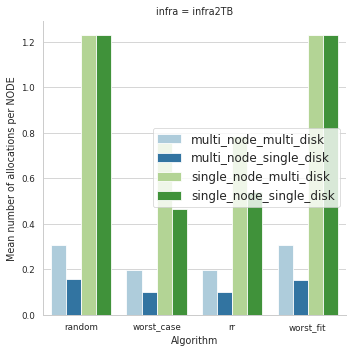

In [108]:
import matplotlib.pyplot as plt
import seaborn as sns

df_data = df_data.sort_values(["system"], ascending=True)

categorical_theme = {
    "context": "paper",            
    "palette": "Paired", 
    "style": "whitegrid", 
    "rc": {
        "axes.spines.right":False, 
        "axes.spines.top": False,
    }
}

algo_order = ["random", "rr", "worst_fit", "worst_case"]
infra_order = ["infra8TB", "infra16TB", "infra64TB"]


# [1] --- Mean number of allocations per node, for every algorithm

sns.set_theme(**categorical_theme)

g = sns.catplot(
    data=df_data, kind="bar",
    x="algo", y="mean_node_alloc", hue="system", col="infra", 
    #col_order=infra_order, order=algo_order,sharey="row",
    height=5, legend=False
)
g.set(ylabel="Mean number of allocations per NODE", xlabel="Algorithm")
plt.legend(fontsize="12", loc="right")


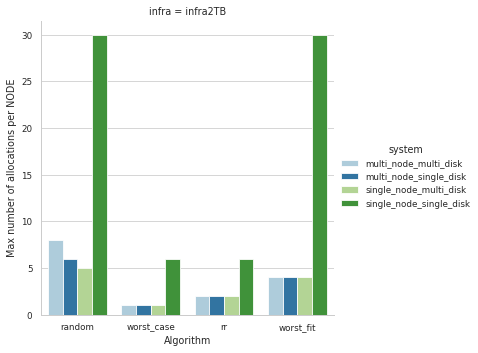

In [109]:
# [2] ---  Max number of allocations per node, for every algo (main parameters of the simulation are in its name)

sns.set_theme(**categorical_theme)

g = sns.catplot(
    data=df_data, kind="bar",
    x="algo", y="max_node_alloc", hue="system", col="infra",
    #col_order=infra_order, order=algo_order, sharey="row",
    height=5
)
g.set(ylabel="Max number of allocations per NODE", xlabel="Algorithm")

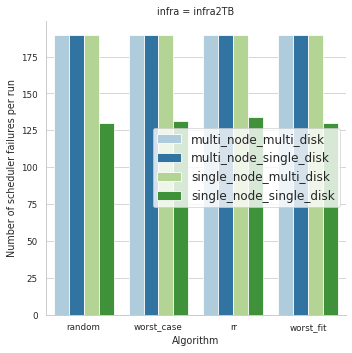

In [110]:
# [3] ---  Total number of scheduler failures, for every simulation

sns.set_theme(**categorical_theme)

g = sns.catplot(
    data=df_data, kind="bar",
    x="algo", y="nb_of_scheduler_failures", hue="system", col="infra", 
    #col_order=infra_order, order=algo_order, sharey="row",
    height=5, legend=False
)
g.set(ylabel="Number of scheduler failures per run", xlabel="Algorithm")
plt.legend(fontsize="12", loc="right")

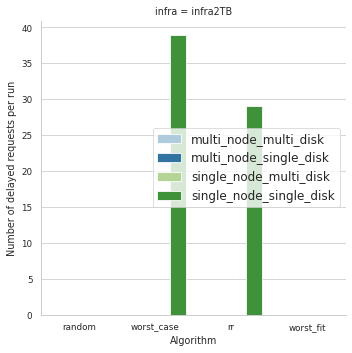

In [111]:
# [4] ---  Total number of delayed requests, for every simulation 

sns.set_theme(**categorical_theme)

g = sns.catplot(
    data=df_data, kind="bar",
    x="algo", y="nb_of_delayed_requests", hue="system", col="infra",
    #col_order=infra_order, order=algo_order, sharey="row",
    height=5, legend=False
)
g.set(ylabel="Number of delayed requests per run", xlabel="Algorithm")
plt.legend(fontsize="12", loc="right")

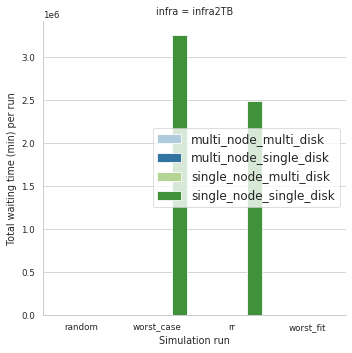

In [112]:
# [5] ---  Total cumulated waiting time for delayed requests, for every simulation
sns.set_theme(**categorical_theme)

g = sns.catplot(
    data=df_data, kind="bar",
    x="algo", y="tt_waiting_time_minutes", hue="system", col="infra",
    #col_order=infra_order, order=algo_order, sharey="row",
    height=5, legend=False
)
g.set(ylabel="Total waiting time (min) per run", xlabel="Simulation run")
plt.legend(fontsize="12", loc="right")

In [113]:
# [6] ---  Create a second dataset where each row is a disk (instead of having one simulation per row)

data_by_disk = {
    "run_name": [],
    "node_id": [],
    "disk_id": [],
    "full_disk_id": [],
    "disk_mean_nb_alloc": [],
    "disk_max_nb_alloc": [],
    "disk_mean_cap_percent": [],
    "disk_max_cap_percent": [],
    "disk_capacity": [],
    "infra": [],
    "system": [],
    "algo": []
}

for idx, row in df_data.iterrows():
    for node in row['nodes']:
        for disk in node["disks"]:
            data_by_disk["run_name"].append(row['full_name'])
            data_by_disk["node_id"].append(node['id'])
            data_by_disk["disk_id"].append(disk['id'])
            data_by_disk["full_disk_id"].append(f"{node['id']}:{disk['id']}")
            data_by_disk["disk_mean_nb_alloc"].append(disk['mean_nb_alloc'])
            data_by_disk["disk_max_nb_alloc"].append(disk['max_alloc'])
            data_by_disk["disk_mean_cap_percent"].append(disk['mean_capacity_utilisation'])
            data_by_disk["disk_max_cap_percent"].append(disk['max_cap_utilisation'])
            data_by_disk["disk_capacity"].append(disk['capacity'])
            data_by_disk["infra"].append(row['infra'])
            data_by_disk["system"].append(row['system'])
            data_by_disk["algo"].append(row['algo'])
    
data_by_disk = pd.DataFrame(data_by_disk)
data_by_disk

,run_name,node_id,disk_id,full_disk_id,disk_mean_nb_alloc,disk_max_nb_alloc,disk_mean_cap_percent,disk_max_cap_percent,disk_capacity,infra,system,algo
0,random_infra2TB_multi_node_multi_disk_IOJobsOct,S-a31ebe:0,0,S-a31ebe:0:0,0.227,5,0.068,79.609,250,infra2TB,multi_node_multi_disk,random
1,random_infra2TB_multi_node_multi_disk_IOJobsOct,S-a31ebe:0,1,S-a31ebe:0:1,0.110,4,0.000,2.820,250,infra2TB,multi_node_multi_disk,random
2,random_infra2TB_multi_node_multi_disk_IOJobsOct,S-a31ebe:1,0,S-a31ebe:1:0,0.160,8,0.001,1.152,250,infra2TB,multi_node_multi_disk,random
3,random_infra2TB_multi_node_multi_disk_IOJobsOct,S-a31ebe:1,1,S-a31ebe:1:1,0.200,3,0.001,1.152,250,infra2TB,multi_node_multi_disk,random
4,random_infra2TB_multi_node_multi_disk_IOJobsOct,S-a31ebe:2,0,S-a31ebe:2:0,0.051,2,0.001,1.152,250,infra2TB,multi_node_multi_disk,random
...,...,...,...,...,...,...,...,...,...,...,...,...
95,rr_infra2TB_single_node_multi_disk_IOJobsOct,S-97a10b:0,7,S-97a10b:0:7,0.107,2,3.902,79.609,250,infra2TB,single_node_multi_disk,rr
96,worst_fit_infra2TB_single_node_single_disk_IOJ...,S-007c88:0,0,S-007c88:0:0,1.231,30,12.885,100.000,2000,infra2TB,single_node_single_disk,worst_fit
97,random_infra2TB_single_node_single_disk_IOJobsOct,S-6c6646:0,0,S-6c6646:0:0,1.231,30,12.885,100.000,2000,infra2TB,single_node_single_disk,random
98,worst_case_infra2TB_single_node_single_disk_IO...,S-317685:0,0,S-317685:0:0,0.465,6,8.848,100.000,2000,infra2TB,single_node_single_disk,worst_case


In [114]:
data_by_disk = data_by_disk.sort_values(["algo",], ascending=True)

In [115]:
categorical_theme_disk = {
    "context": "paper",            
    "palette": "colorblind", 
    "style": "whitegrid", 
}

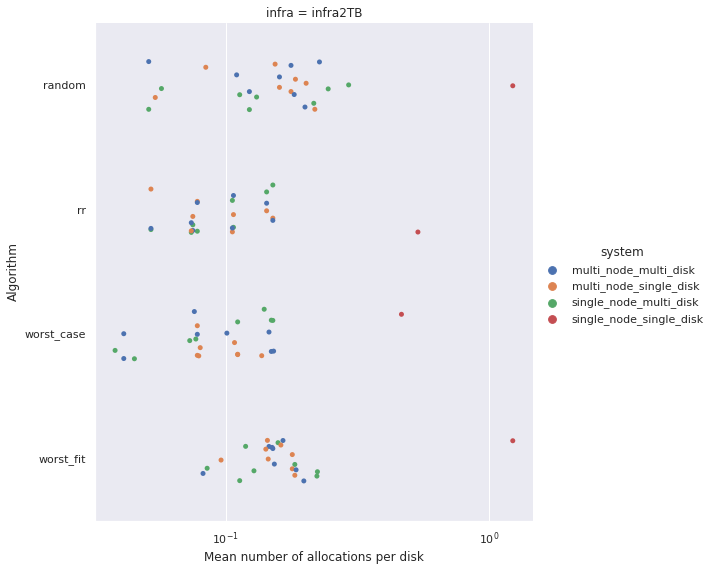

In [116]:
# [7] ---  Mean number of allocations per disk, organised by simulation run and infrastructure.

sns.set(rc={'figure.figsize':(11.7,8.27)})
# sns.set_theme(**categorical_theme_disk)

g = sns.catplot(
    data=data_by_disk, kind="strip",
    y="algo", x="disk_mean_nb_alloc",hue="system", col="infra",
    height=8, jitter=0.2
)
g.set(xscale="log")
g.set_axis_labels("Mean number of allocations per disk", "Algorithm")

[Text(0, 0.5, 'Simulation run'),
 Text(0.5, 0, 'Mean number of allocations per node')]

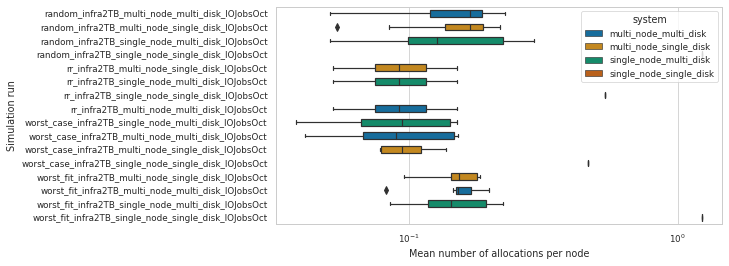

In [117]:
# [8] ---  Mean number of allocations per disk, organised by simulation run and infrastructure.

# sns.set(rc={'figure.figsize':(29.7,21)})
sns.set(rc={'figure.figsize':(8,4)})
sns.set_theme(**categorical_theme_disk)


g = sns.boxplot(
    data=data_by_disk,
    y="run_name", x="disk_mean_nb_alloc", hue="system", 
    dodge=False, width=0.5
)
g.set(xscale="log")
g.set(ylabel="Simulation run", xlabel="Mean number of allocations per node")

[Text(0, 0.5, 'Mean nb. of allocations'), Text(0.5, 0, 'Scheduling algorithm')]

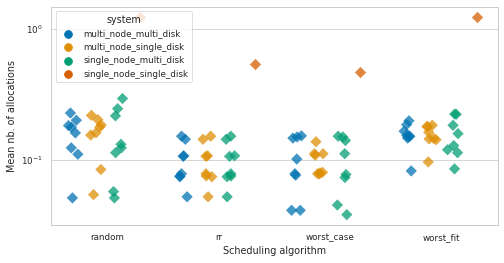

In [118]:
# [9] ---  Mean number of allocations per disk, per algorithm (alt)

sns.set_theme(**categorical_theme_disk)

g = sns.stripplot(
    data=data_by_disk,
    y="disk_mean_nb_alloc", x="algo",
    hue="system", marker="D",  alpha=.75, dodge=True, size=8, jitter=0.2
)
g.set(yscale="log")
g.set(ylabel="Mean nb. of allocations", xlabel="Scheduling algorithm")

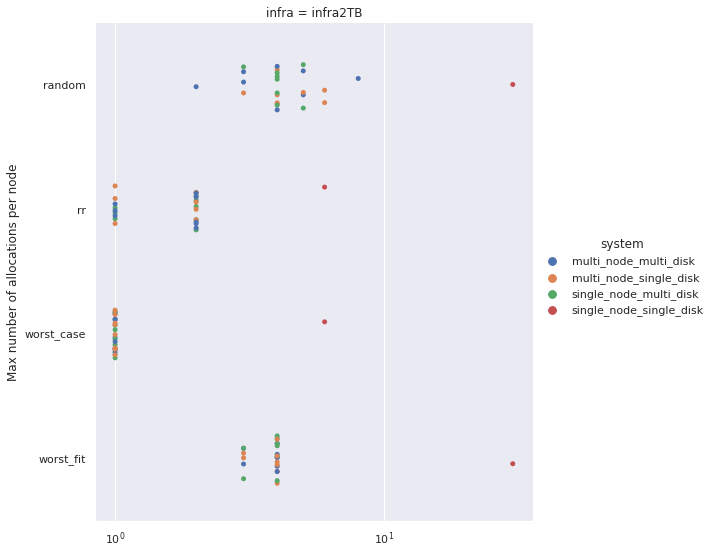

In [119]:
# [10] ---  Max number of allocations per disk, organised by simulation run and infrastructure (1/2)

sns.set(rc={'figure.figsize':(11.7,8.27)})
#sns.set_theme(**categorical_theme_disk)

g = sns.catplot(
    data=data_by_disk, kind="strip", col="infra",
    y="algo", x="disk_max_nb_alloc",hue="system",
    height=8, jitter=0.2,
)
g.set(xscale="log")
g.set_axis_labels("", "Max number of allocations per node")

[Text(0, 0.5, 'Simulation run'),
 Text(0.5, 0, 'Max number of allocations per node')]

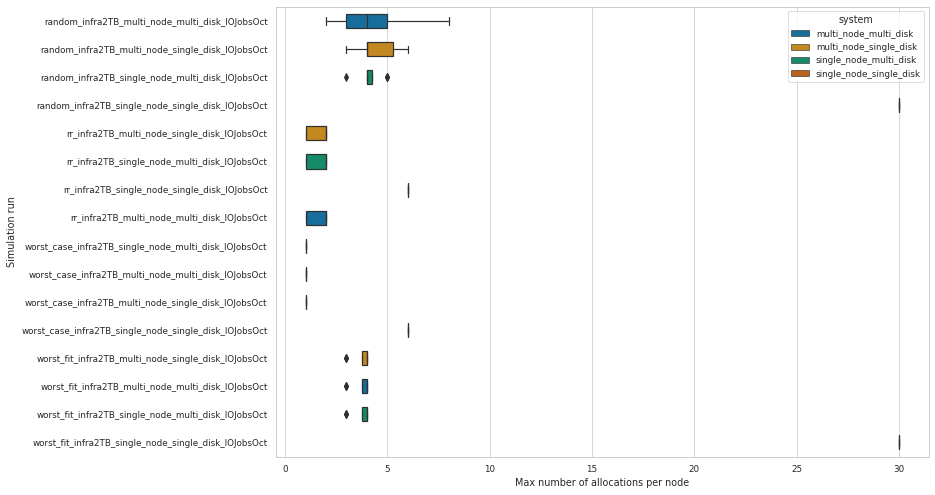

In [120]:
# [11] ---  Max number of allocations per disk, organised by simulation run and infrastructure (2/2)

sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_theme(**categorical_theme_disk)


g = sns.boxplot(
    data=data_by_disk,
    y="run_name", x="disk_max_nb_alloc", hue="system", 
    dodge=False, width=0.5
)
g.set(ylabel="Simulation run", xlabel="Max number of allocations per node")

[Text(0, 0.5, 'Max nb. of allocations'), Text(0.5, 0, 'Scheduling algorithm')]

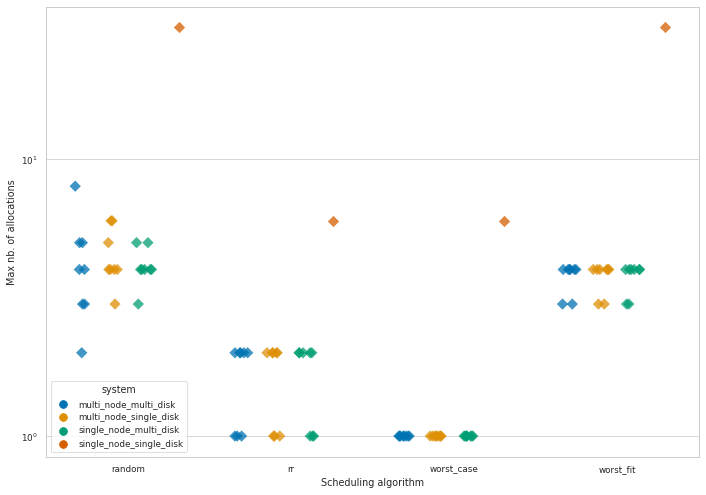

In [121]:
# [12] ---  Max number of allocations per disk, per algorithm (alt)

sns.set_theme(**categorical_theme_disk)

g = sns.stripplot(
    data=data_by_disk,
    y="disk_max_nb_alloc", x="algo",
    hue="system", marker="D",  alpha=.75, dodge=True, size=8, jitter=0.2
)
g.set(yscale="log")
g.set(ylabel="Max nb. of allocations", xlabel="Scheduling algorithm")

[Text(0, 0.5, 'Mean capacity utilisation'),
 Text(0.5, 0, 'Scheduling algorithm')]

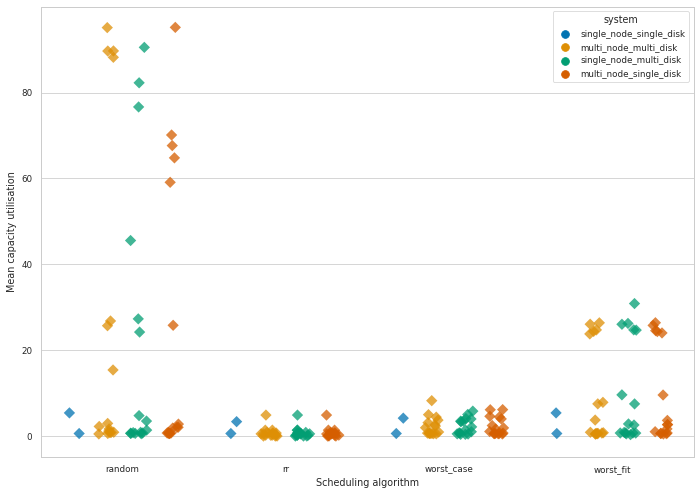

In [43]:
# [13] ---  Mean capacity utilisation per disk, per algorithm

sns.set_theme(**categorical_theme_disk)

g = sns.stripplot(
    data=data_by_disk,
    y="disk_mean_cap_percent", x="algo",
    hue="system", marker="D",  alpha=.75, dodge=True, size=8, jitter=0.2
)
g.set(ylabel="Mean capacity utilisation", xlabel="Scheduling algorithm")

[Text(0, 0.5, 'Max capacity utilisation'),
 Text(0.5, 0, 'Scheduling algorithm')]

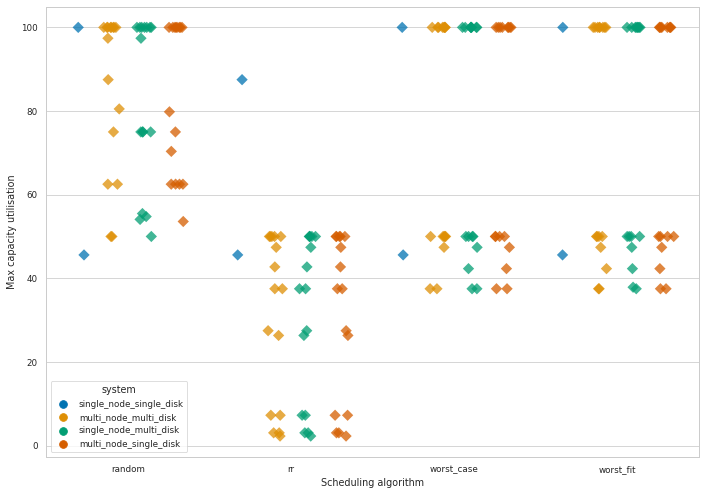

In [44]:
# [14] --- Max capacity utilisation per disk, per algorithm

sns.set_theme(**categorical_theme_disk)

g = sns.stripplot(
    data=data_by_disk,
    y="disk_max_cap_percent", x="algo",
    hue="system", marker="D",  alpha=.75, dodge=True, size=8, jitter=0.2
)
g.set(ylabel="Max capacity utilisation", xlabel="Scheduling algorithm")

In [45]:
data_by_disk_mean_alloc = data_by_disk.sort_values(["disk_mean_nb_alloc",], ascending=True)

[None]

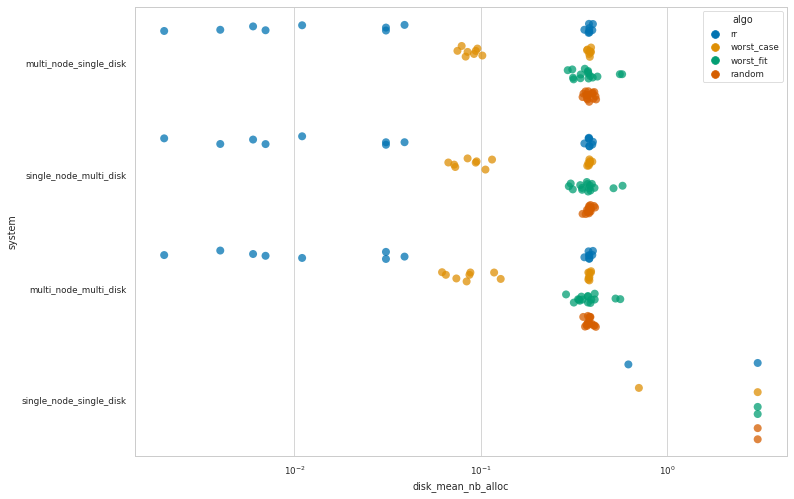

In [46]:
# [15] --- Disk mean nb alloc per run, with hue on Node ID 

sns.set_theme(**categorical_theme_disk)

g = sns.stripplot(
    data=data_by_disk_mean_alloc,
    y="system", x="disk_mean_nb_alloc",size=8, jitter=0.2, alpha=0.75,
    dodge=True,
    hue="algo"
)
g.set(xscale="log")


# g.xaxis.grid(True, "minor", linewidth=.25)
#g = sns.catplot(x="disk_mean_nb_alloc", y="run_name",
#                hue="node_id",
#                data=data_by_disk_sorted, kind="swarm",
#                alpha=.6, height=21, aspect=29.7/21);

#g.set(xscale="log")
# g.xaxis.grid(True, "minor", linewidth=.25)

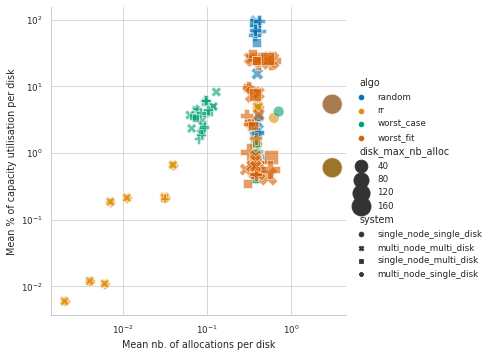

In [47]:
# [16] --- Disk mean nb of alloc compared to disk mean capacity utilisation

sns.set_theme(**categorical_theme_disk)

sns.set_style("whitegrid")
g = sns.relplot(
    x="disk_mean_nb_alloc", 
    y="disk_mean_cap_percent", 
    hue="algo", 
    style="system",
    size="disk_max_nb_alloc",
    sizes=(100, 400), 
    alpha=.60,
    height=5, 
    data=data_by_disk
)
g.set(
    xscale="log", 
    yscale="log", 
    xlabel="Mean nb. of allocations per disk", 
    ylabel="Mean % of capacity utilisation per disk"
)

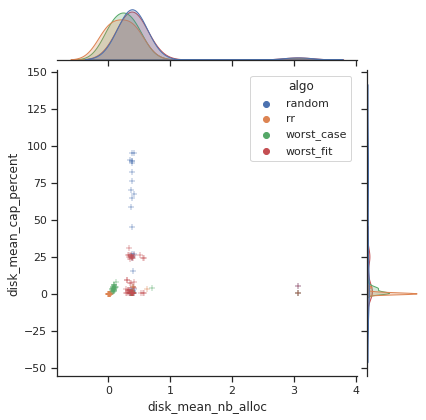

In [48]:
# [16] ---

sns.set_theme(style="ticks")

cmap = sns.hls_palette(n_colors=data_by_disk['algo'].nunique())

g = sns.jointplot(data=data_by_disk, x="disk_mean_nb_alloc", 
                  y="disk_mean_cap_percent", 
                  hue="algo", marker="+")
#g.set(
#    xscale="log", 
#    yscale="log", 
#    xlabel="Mean nb. of allocations per disk", 
#    ylabel="Mean % of capacity utilisation per disk"
#)